In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import datetime
%load_ext tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.makedirs('/content/drive/MyDrive/model_checkpoints_septt16/', exist_ok=True)

In [4]:
log_dir = "/content/drive/MyDrive/model_checkpoints/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [5]:
import os

# Example path to the shared folder
folder_path = '/content/drive/My Drive/org-data'

# List files in the folder
files = os.listdir(folder_path)
print(files)


['low', 'high']


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path, prefix):
    images = {}
    for filename in os.listdir(folder_path):
        if filename.startswith(prefix):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.convert('L')  # Convert to grayscale
                  # Resize image to the given size
                img_array = np.array(img)  # Convert image to numpy array
                index = int(filename.split('_')[1].split('.')[0])
                images[index] = img_array
    return images

def prepare_data(high_quality_path, low_quality_path):
    high_quality_images = load_images_from_folder(high_quality_path, 'high_')
    low_quality_images = load_images_from_folder(low_quality_path, 'low_')

    common_indices = sorted(set(high_quality_images.keys()) & set(low_quality_images.keys()))
    high_quality_list = [high_quality_images[i] for i in common_indices]
    low_quality_list = [low_quality_images[i] for i in common_indices]

    # Ensure the images have the correct shape

    high_quality_list = np.expand_dims(np.array(high_quality_list), axis=-1)
    low_quality_list = np.expand_dims(np.array(low_quality_list), axis=-1)

    return low_quality_list, high_quality_list

# Paths to folders containing high-quality and low-quality images
high_quality_path = '/content/drive/MyDrive/org-data/high'
low_quality_path = '/content/drive/MyDrive/org-data/low'

# Desired image size (width, height)


# Prepare data
X, Y = prepare_data(high_quality_path, low_quality_path)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

In [ ]:
def plot_images_pair(low_img, high_img, index):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(low_img, cmap='gray')  # Use 'gray' for grayscale images
    plt.title(f'Low Quality Image {index}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(high_img, cmap='gray')  # Use 'gray' for grayscale images
    plt.title(f'High Quality Image {index}')
    plt.axis('off')

    plt.show()

plot_images_pair(X[7], Y[7], 7)

In [ ]:
X= X/255
Y= Y/255

In [ ]:
def plot_images_pair(low_img, high_img, index):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(low_img, cmap='gray')  # Use 'gray' for grayscale images
    plt.title(f'Low Quality Image {index}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(high_img, cmap='gray')  # Use 'gray' for grayscale images
    plt.title(f'High Quality Image {index}')
    plt.axis('off')

    plt.show()

plot_images_pair(X[3005], Y[3005], 7)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU
from tensorflow.keras.layers import Input, Conv2DTranspose, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

# Subpixel Convolution Layer (PixelShuffle)
def SubpixelConv2D(scale=2):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale))

# Residual Block with L2 Regularization
def residual_block(input_layer, filters, l2_reg=0.001):
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2_reg))(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_layer])  # Skip connection
    x = ReLU()(x)
    return x

# PSNR (Peak Signal-to-Noise Ratio) Metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Custom Loss Function (L1 + MSSIM)
def custom_loss(y_true, y_pred, alpha=0.8):
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    mssim_loss_value = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * l1_loss + (1 - alpha) * mssim_loss_value

# U-Net with Residuals, L2 Regularization, and Custom Loss + Metrics
def unet_with_residuals(input_size=(128, 128, 1), l2_reg=0.001):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(64, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(128, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(256, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(512, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(l2_reg))(conv4)
    merge5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(256, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    conv5 = Conv2D(256, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(l2_reg))(conv5)
    merge6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    conv6 = Conv2D(128, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(l2_reg))(conv6)
    merge7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    conv7 = Conv2D(64, 3, activation=None, padding='same', kernel_regularizer=l2(l2_reg))(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)

    # Subpixel Convolution Layer for Upsampling
    conv8 = Conv2D(256, 3, padding='same', kernel_regularizer=l2(l2_reg))(conv7)  # Ensure filters are divisible by 4 for scale=2
    subpixel = SubpixelConv2D(scale=2)(conv8)

    # Residual Blocks
    residual = residual_block(subpixel, 64, l2_reg)
    residual = residual_block(residual, 64, l2_reg)
    residual = residual_block(residual, 64, l2_reg)

    # Final Output Layer
    conv9 = Conv2D(1, 1, activation='sigmoid', kernel_regularizer=l2(l2_reg))(residual)

    model = Model(inputs, conv9)

    # Compile the model with custom loss and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=lambda y_true, y_pred: custom_loss(y_true, y_pred),
                  metrics=[psnr_metric, 'mae'])

    return model


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
# Create U-Net model
model = unet_with_residuals()  # Adjust channels if needed (e.g., 3 for RGB)
#model.summary()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/model_checkpoints_septt16/sept16/epoch_{epoch:02d}.keras'

# Create the ModelCheckpoint callback to save every 10 epochs
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',  # Save at the end of each epoch
    save_weights_only=False,  # Save the whole model (architecture + optimizer + weights)
    verbose=1  # Print when saving model
)


In [ ]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_freq=10):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

# Create the custom checkpoint callback
custom_checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    save_freq=10  # Save every 10 epochs
)

In [ ]:
# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the model with the best weights
)

In [ ]:
# import tensorflow as tf

# # Learning Rate Scheduler callback
# def scheduler(epoch, lr):
#     if epoch < 50:
#         return float(lr)  # Ensure lr is a float
#     else:
#         return float(lr * tf.math.exp(-0.1))  # Decrease the learning rate and ensure it's a float

# learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
# Combine all callbacks
callbacks = [
    tensorboard_callback,

    custom_checkpoint_callback,
    early_stopping_callback,
    # learning_rate_scheduler
]

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/model_checkpoints/epoch_30.keras')
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

# Save the model
model.save('unet_kankey.keras')

c:\Users\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 182 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


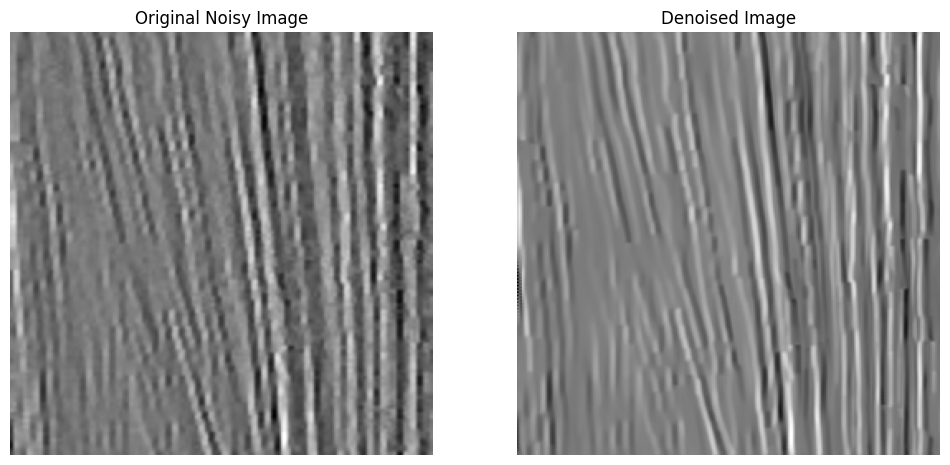

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Load and preprocess an image."""
    with Image.open(image_path) as img:
        img = img.convert('L')  # Convert to grayscale
     
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def postprocess_image(image_array):
    """Convert the model output back to image format."""
    img_array = np.squeeze(image_array)  # Remove batch and channel dimensions
    img_array = img_array * 255.0  # Rescale to [0, 255]
    img_array = np.clip(img_array, 0, 255)  # Clip values to valid range
    img_array = img_array.astype(np.uint8)  # Convert to uint8 type
    return Image.fromarray(img_array)

def visualize_images(original, denoised):
    """Visualize the original and denoised images."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Noisy Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised Image')
    plt.axis('off')

    plt.show()

# Paths and settings
test_image_path = 'low_test.jpg'  # Path to a noisy test image
img_size = (256, 256)

# Load and preprocess the test image
test_image = preprocess_image(test_image_path)

# Load the trained model
model = unet_with_residuals()
model.load_weights('unet_0.4.keras')  # Load the model weights

# Make prediction
denoised_image_array = model.predict(test_image)

# Postprocess the output
denoised_image = postprocess_image(denoised_image_array[0])

# Load the original noisy image for comparison
original_image = Image.open(test_image_path).convert('L').resize(img_size)

# Visualize results
visualize_images(original_image, denoised_image)


In [1]:
import cv2

In [16]:
image= cv2.imread("test.jpg")
img= cv2.resize(image,(128,128))

In [17]:
image= cv2.imwrite( "low_test.jpg",img)

In [ ]:
model.save("unet1.keras")

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Move the file to Google Drive
!cp /content/unet_3000images_100epoch.keras /content/drive/MyDrive/
